In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib
import os


Matplotlib is building the font cache; this may take a moment.


In [2]:
def charger_et_preparer_donnees(chemin_fichier):
    """Charge et prépare les données."""
    df = pd.read_csv(chemin_fichier)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.set_index('Date')
    df = df.sort_index()
    return df

In [3]:
def traiter_service(service_df):
    """Traite les données pour un service donné."""
    service_df = service_df.drop('Service', axis=1)

    if service_df.index.duplicated().any():
        print("Doublons dans l'index de date détectés.")
        service_df = service_df[~service_df.index.duplicated(keep='first')]
    service_df = service_df.asfreq('D')

    for col in service_df.columns:
        service_df[col] = pd.to_numeric(service_df[col], errors='coerce')

    numeric_cols = service_df.select_dtypes(include=[np.number]).columns.tolist()
    service_df = service_df[numeric_cols]

    service_df['jour_annee'] = service_df.index.dayofyear
    service_df['mois'] = service_df.index.month
    service_df['jour_semaine'] = service_df.index.dayofweek
    return service_df


In [4]:
def diviser_donnees(service_df):
    """Divise les données en ensembles d'entraînement et de test."""
    y_regression = service_df['Admissions']
    X_regression = service_df.drop(['Admissions'], axis=1)

    train_size = int(len(service_df) * 0.8)
    train_data = service_df[:train_size]
    test_data = service_df[train_size:]

    y_train_regression = train_data['Admissions']
    y_test_regression = test_data['Admissions']

    X_train_regression = train_data.drop('Admissions', axis=1)
    X_test_regression = test_data.drop('Admissions', axis=1)
    return X_train_regression, X_test_regression, y_train_regression, y_test_regression

In [5]:
def entrainer_modeles(X_train_regression, y_train_regression, service):
    """Entraîne les modèles de régression."""
    lr = LinearRegression()
    lr.fit(X_train_regression, y_train_regression)

    param_file_rf = f"rf_params_{service}.joblib"
    if os.path.exists(param_file_rf):
        best_params_rf = joblib.load(param_file_rf)
        if 'random_state' in best_params_rf:
            del best_params_rf['random_state']
        rf = RandomForestRegressor(**best_params_rf, random_state=42)
    else:
        param_grid_rf = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=3)
        grid_search_rf.fit(X_train_regression, y_train_regression)
        best_rf = grid_search_rf.best_estimator_
        joblib.dump(best_rf.get_params(), param_file_rf)
        rf = best_rf

    rf.fit(X_train_regression, y_train_regression)

    param_file_gbr = f"gbr_params_{service}.joblib"
    if os.path.exists(param_file_gbr):
        best_params_gbr = joblib.load(param_file_gbr)
        if 'random_state' in best_params_gbr:
            del best_params_gbr['random_state']
        gbr = GradientBoostingRegressor(**best_params_gbr, random_state=42)
    else:
        param_grid_gbr = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0]
        }
        grid_search_gbr = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid_gbr, cv=3)
        grid_search_gbr.fit(X_train_regression, y_train_regression)
        best_gbr = grid_search_gbr.best_estimator_
        joblib.dump(best_gbr.get_params(), param_file_gbr)
        gbr = best_gbr

    gbr.fit(X_train_regression, y_train_regression)
    return lr, rf, gbr

In [6]:
def evaluer_modeles(lr, rf, gbr, X_test_regression, y_test_regression):
    """Évalue les modèles et affiche les résultats."""
    lr_pred = lr.predict(X_test_regression)
    rf_pred = rf.predict(X_test_regression)
    gbr_pred = gbr.predict(X_test_regression)

    lr_mse = mean_squared_error(y_test_regression, lr_pred)
    lr_mae = mean_absolute_error(y_test_regression, lr_pred)
    rf_mse = mean_squared_error(y_test_regression, rf_pred)
    rf_mae = mean_absolute_error(y_test_regression, rf_pred)
    gbr_mse = mean_squared_error(y_test_regression, gbr_pred)
    gbr_mae = mean_absolute_error(y_test_regression, gbr_pred)

    mae_table = pd.DataFrame({
        'Modèle': ['Régression linéaire', 'Forêt aléatoire', 'Gradient Boosting'],
        'MAE': [lr_mae, rf_mae, gbr_mae],
        'MSE': [lr_mse, rf_mse, gbr_mse]
    })
    print("\nTableau des écarts moyens (MAE) :")
    print(mae_table)
    return lr_pred, rf_pred, gbr_pred

In [7]:
def gestion_stocks(service_df, gbr_pred, test_data):
    """Gère les stocks et affiche les commandes."""
    stock_consommables = service_df['Stock Consommables'].iloc[-1]
    stock_medicaments = service_df['Stock Médicaments'].iloc[-1]
    seuil_commande_consommables = 3000
    seuil_commande_medicaments = 700
    consommation_par_admission_consommables = 25
    consommation_par_admission_medicaments = 6

    quantite_commandee_consommables = 0
    quantite_commandee_medicaments = 0
    commandes = []

    for i, prediction in enumerate(gbr_pred):
        stock_consommables -= prediction * consommation_par_admission_consommables
        stock_medicaments -= prediction * consommation_par_admission_medicaments

        date = test_data.index[i].strftime('%Y-%m-%d')
        commande_consommables = 0
        commande_medicaments = 0

        if stock_consommables < seuil_commande_consommables:
            commande_consommables = seuil_commande_consommables - stock_consommables + 1500
            quantite_commandee_consommables += commande_consommables
            stock_consommables += commande_consommables

        if stock_medicaments < seuil_commande_medicaments:
            commande_medicaments = seuil_commande_medicaments - stock_medicaments + 400
            quantite_commandee_medicaments += commande_medicaments
            stock_medicaments += commande_medicaments

        if commande_consommables > 0 or commande_medicaments > 0:
            commandes.append([date, commande_consommables, commande_medicaments])

    if commandes:
        commandes_df = pd.DataFrame(commandes, columns=['Date', 'Consommables', 'Médicaments'])
        commandes_df['Consommables'] = commandes_df['Consommables'].apply(lambda x: "{:,}".format(x))
        commandes_df['Médicaments'] = commandes_df['Médicaments'].apply(lambda x: "{:,}".format(x))

        print("\nTableau des commandes (15 premières lignes) :")
        display(commandes_df.head(10))
    else:
        print("\nAucune commande nécessaire.")


In [12]:
def visualiser_predictions(y_test_regression, lr_pred, rf_pred, gbr_pred, service):
    """Visualise les prédictions et les enregistre en PNG."""
    if not os.path.exists('graphiques'):
        os.makedirs('graphiques')

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_regression.index, y_test_regression, label='Valeurs réelles')
    plt.plot(y_test_regression.index, lr_pred, label='Régression linéaire')
    plt.plot(y_test_regression.index, rf_pred, label='Forêt aléatoire')
    plt.plot(y_test_regression.index, gbr_pred, label='Gradient Boosting')
    plt.legend()
    plt.title(f'Prédictions pour le service {service}')
    plt.show()

    plt.savefig(f'graphiques/predictions_{service}.png')
    plt.close()

Service: Orthopédie

Tableau des écarts moyens (MAE) :
                Modèle       MAE       MSE
0  Régression linéaire  2.059383  7.052572
1      Forêt aléatoire  1.904863  5.955932
2    Gradient Boosting  1.793260  5.536054

Tableau des commandes (15 premières lignes) :


,Date,Consommables,Médicaments
0,2024-05-26,"1,514.1700077399178",0.0
1,2024-05-27,0.0,506.58689098267166
2,2024-05-28,"1,509.9175584589084",0.0
3,2024-05-30,0.0,525.1633805544654
4,2024-05-31,"2,222.3208143093166",0.0
5,2024-06-02,"1,547.200841995801",557.8759418638094
6,2024-06-04,"1,526.7869910930567",0.0
7,2024-06-05,0.0,543.3102229609435
8,2024-06-06,"1,511.4172057787237",0.0
9,2024-06-08,0.0,541.7029734725321


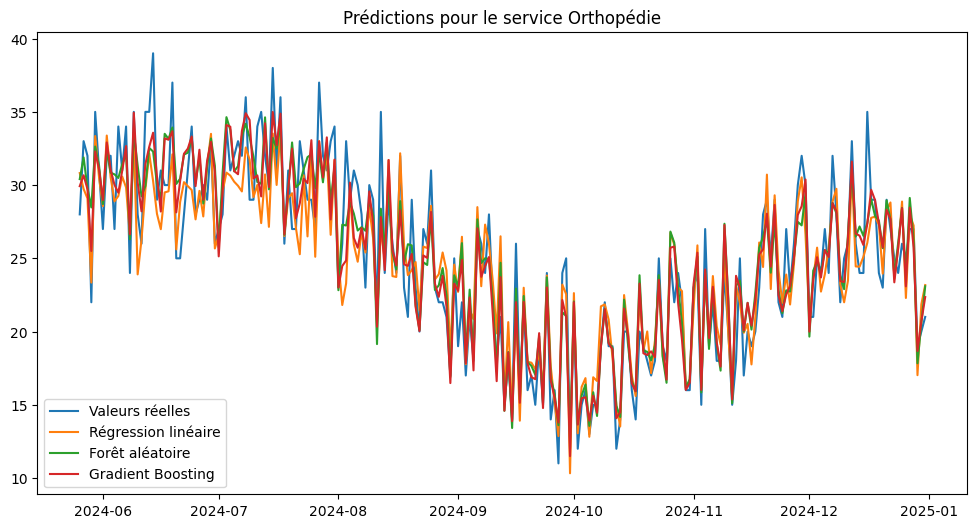

Service: Pneumologie

Tableau des écarts moyens (MAE) :
                Modèle       MAE       MSE
0  Régression linéaire  1.443946  3.306916
1      Forêt aléatoire  1.335135  3.052025
2    Gradient Boosting  1.255571  2.859090

Tableau des commandes (15 premières lignes) :


,Date,Consommables,Médicaments
0,2024-05-26,"1,550.8508854779902",0.0
1,2024-05-27,0.0,527.2663540200631
2,2024-05-29,"1,785.2908932419132",0.0
3,2024-05-30,0.0,407.7832894632214
4,2024-06-01,"1,663.7847380123367",0.0
5,2024-06-02,0.0,407.60223989622966
6,2024-06-04,"1,652.2283081097553",0.0
7,2024-06-05,0.0,415.86034822662793
8,2024-06-08,"1,932.2313330736324",0.0
9,2024-06-09,0.0,412.2259621742462


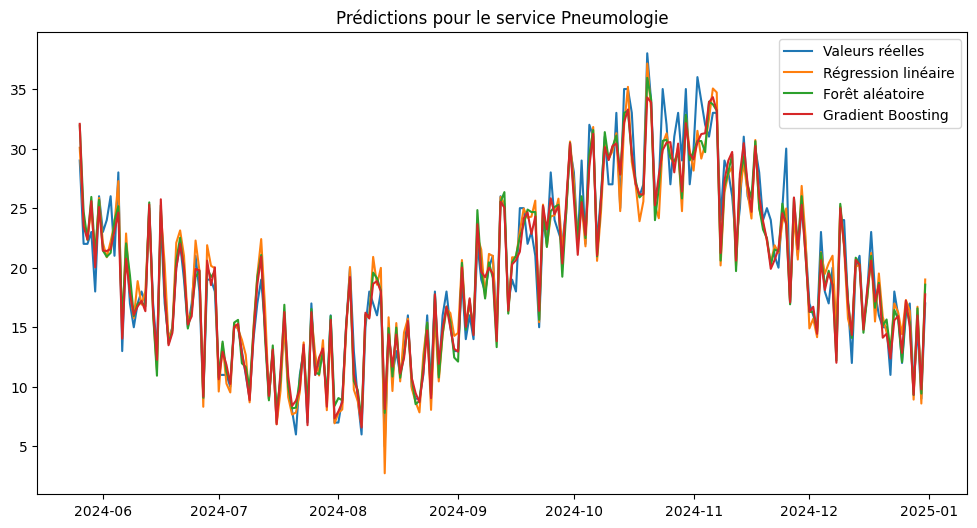

In [13]:
# Charger les données et regrouper par service
data = charger_et_preparer_donnees('dataSet_Hopital.csv')
grouped = data.groupby('Service')

# Pour chaque service
for service, service_df in grouped:
    print(f"Service: {service}")

    # Traiter les données pour ce service
    service_df = traiter_service(service_df)

    # Diviser les données en ensembles d'entraînement et de test
    X_train_regression, X_test_regression, y_train_regression, y_test_regression = diviser_donnees(service_df)

    # Entraîner les modèles
    lr, rf, gbr = entrainer_modeles(X_train_regression, y_train_regression, service)

    # Évaluer les modèles
    lr_pred, rf_pred, gbr_pred = evaluer_modeles(lr, rf, gbr, X_test_regression, y_test_regression)

    # Gérer les stocks et afficher les commandes
    gestion_stocks(service_df, gbr_pred, X_test_regression)

    # Visualiser les prédictions
    visualiser_predictions(y_test_regression, lr_pred, rf_pred, gbr_pred, service)